# 16 - Control blocks (mixed-domain)

Exemplos praticos dos blocos de controle novos:

- `op_amp`, `comparator`, `pi_controller`, `pid_controller`;
- `math_block`, `pwm_generator`, `integrator`, `differentiator`;
- `limiter`, `rate_limiter`, `hysteresis`;
- `lookup_table`, `transfer_function`, `delay_block`, `sample_hold`;
- `state_machine`, `signal_mux`, `signal_demux`.


In [1]:
from pathlib import Path
import sys

_root = Path.cwd()
_candidates = []
for _ in range(6):
    for _rel in (("build-test", "python"), ("build", "python")):
        candidate = _root / _rel[0] / _rel[1]
        if candidate.is_dir():
            _candidates.append(candidate)
    _root = _root.parent

_seen = set()
for candidate in _candidates:
    cstr = str(candidate)
    if cstr in _seen:
        continue
    _seen.add(cstr)
    if cstr not in sys.path:
        sys.path.insert(0, cstr)

import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt

print(f"Pulsim version: {ps.__version__}")


Pulsim version: 0.3.3


In [2]:
circuit = ps.Circuit()

n_ref = circuit.add_node("ref")
n_fb = circuit.add_node("fb")
n_aux = circuit.add_node("aux")
n_sel = circuit.add_node("sel")
gnd = circuit.ground()

circuit.add_virtual_component(
    "op_amp",
    "OA1",
    [n_ref, n_fb, n_aux],
    {"open_loop_gain": 2e4, "rail_low": 0.0, "rail_high": 5.0},
    {},
)
circuit.add_virtual_component(
    "comparator",
    "CMP1",
    [n_ref, n_fb, n_aux],
    {"threshold": 0.0, "hysteresis": 0.05, "high": 5.0, "low": 0.0},
    {},
)
circuit.add_virtual_component(
    "pi_controller",
    "PI1",
    [n_ref, n_fb, n_aux],
    {"kp": 0.6, "ki": 180.0, "output_min": 0.0, "output_max": 1.0, "anti_windup": 1.0},
    {},
)
circuit.add_virtual_component(
    "pid_controller",
    "PID1",
    [n_ref, n_fb, n_aux],
    {
        "kp": 0.5,
        "ki": 120.0,
        "kd": 0.0008,
        "output_min": 0.0,
        "output_max": 1.0,
        "anti_windup": 1.0,
    },
    {},
)

circuit.add_virtual_component("math_block", "ADD1", [n_ref, n_fb], {}, {"operation": "add"})
circuit.add_virtual_component("math_block", "SUB1", [n_ref, n_fb], {}, {"operation": "sub"})
circuit.add_virtual_component("math_block", "MUL1", [n_ref, n_fb], {}, {"operation": "mul"})
circuit.add_virtual_component("math_block", "DIV1", [n_ref, n_fb], {}, {"operation": "div"})

circuit.add_virtual_component(
    "pwm_generator",
    "PWM1",
    [n_aux],
    {
        "frequency": 80_000.0,
        "duty_from_input": 1.0,
        "duty_gain": 1.0,
        "duty_offset": 0.0,
        "duty_min": 0.05,
        "duty_max": 0.95,
    },
    {},
)

circuit.add_virtual_component(
    "integrator",
    "INT1",
    [n_ref, n_fb],
    {"output_min": -2.0, "output_max": 2.0},
    {},
)
circuit.add_virtual_component(
    "differentiator",
    "DIF1",
    [n_ref, n_fb],
    {"alpha": 0.85, "output_min": -5.0, "output_max": 5.0},
    {},
)
circuit.add_virtual_component("limiter", "LIM1", [n_ref, n_fb], {"min": -0.25, "max": 0.25}, {})
circuit.add_virtual_component(
    "rate_limiter",
    "RAT1",
    [n_ref, n_fb],
    {"rising_rate": 3_000.0, "falling_rate": 3_000.0, "output_min": -1.0, "output_max": 1.0},
    {},
)
circuit.add_virtual_component(
    "hysteresis",
    "HYS1",
    [n_ref, n_fb],
    {"threshold": 0.0, "hysteresis": 0.06, "high": 1.0, "low": -1.0},
    {},
)

circuit.add_virtual_component(
    "lookup_table",
    "LUT1",
    [n_ref, n_fb],
    {},
    {"x": "[-1.0, -0.2, 0.0, 0.2, 1.0]", "y": "[-1.5, -0.1, 0.0, 0.1, 1.5]", "mode": "linear"},
)
circuit.add_virtual_component(
    "transfer_function",
    "TF1",
    [n_ref, n_fb],
    {},
    {"num": "[0.15, 0.15]", "den": "[1.0, -0.7]"},
)
circuit.add_virtual_component("delay_block", "DEL1", [n_ref, n_fb], {"delay": 50e-6}, {})
circuit.add_virtual_component("sample_hold", "SH1", [n_ref, n_fb], {"sample_period": 60e-6}, {})

circuit.add_virtual_component(
    "state_machine",
    "SM1",
    [n_sel],
    {"threshold": 0.5, "high": 1.0, "low": 0.0},
    {"mode": "toggle"},
)
circuit.add_virtual_component("signal_mux", "MUX1", [n_ref, n_fb, n_aux], {"select_index": 2.0}, {})
circuit.add_virtual_component("signal_demux", "DMX1", [n_ref, n_fb, n_aux], {}, {})

print(f"Virtual components: {circuit.num_virtual_components()}")
print("Phase order:", ps.Circuit.mixed_domain_phase_order())
print("Canais disponiveis:", len(circuit.virtual_channel_metadata()))


Virtual components: 21
Phase order: ['electrical', 'control', 'events', 'instrumentation']
Canais disponiveis: 22


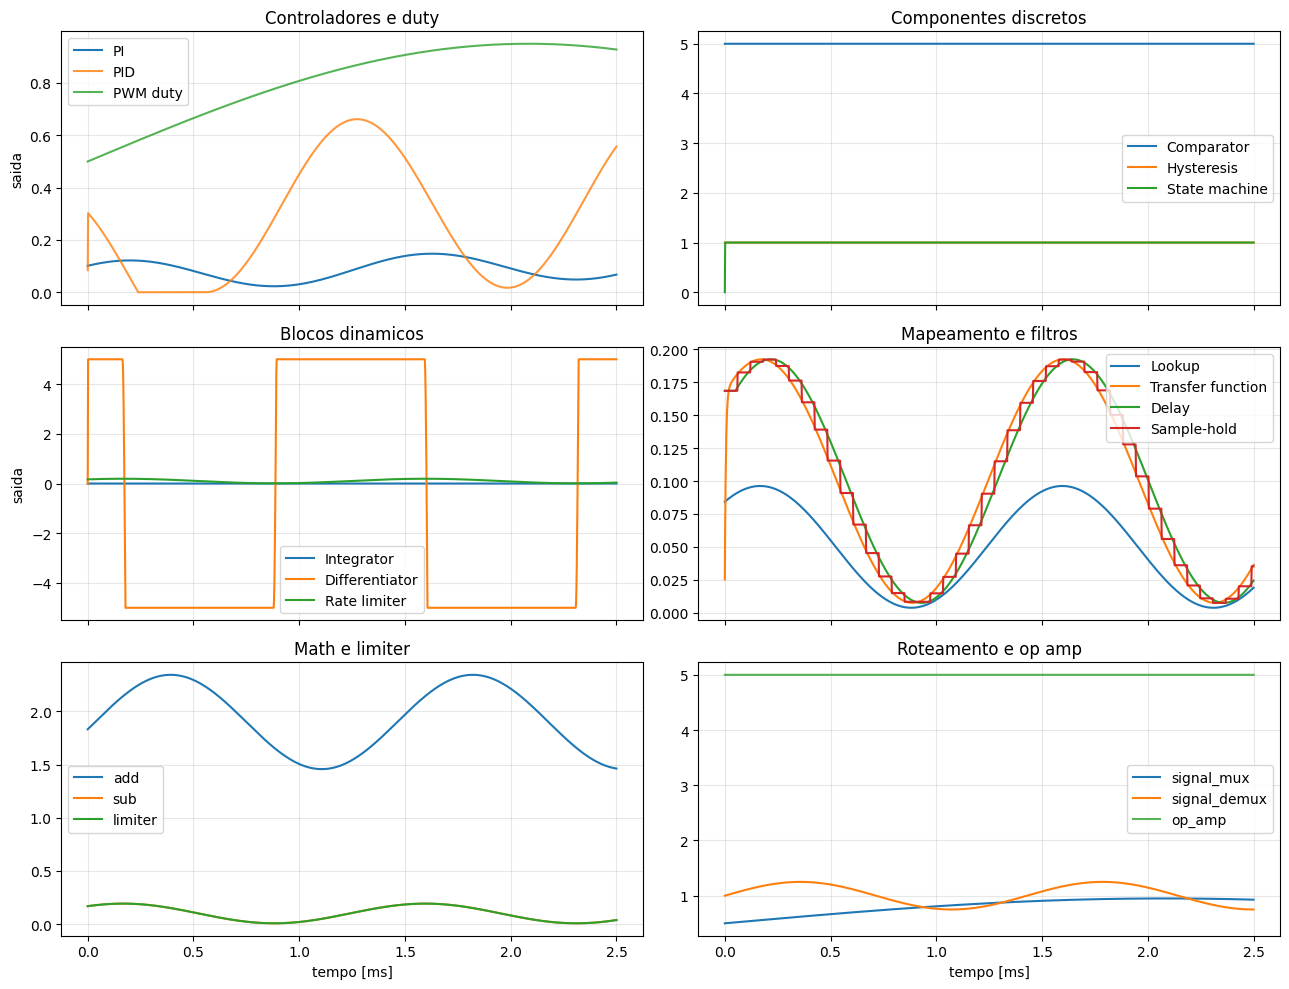

In [3]:
t_end = 2.5e-3
steps = 1400
times = np.linspace(0.0, t_end, steps)

channels = {
    "PI1": [],
    "PID1": [],
    "PWM1": [],
    "PWM1.duty": [],
    "CMP1": [],
    "HYS1": [],
    "SM1": [],
    "INT1": [],
    "DIF1": [],
    "LIM1": [],
    "RAT1": [],
    "TF1": [],
    "DEL1": [],
    "SH1": [],
    "LUT1": [],
    "OA1": [],
    "ADD1": [],
    "SUB1": [],
    "MUX1": [],
    "DMX1": [],
}

for t in times:
    x = np.zeros(circuit.system_size())
    ref = 1.0 + 0.25 * np.sin(2.0 * np.pi * 700.0 * t)
    fb = 0.9 + 0.20 * np.sin(2.0 * np.pi * 700.0 * t - 0.35)
    aux = 0.5 + 0.45 * np.sin(2.0 * np.pi * 120.0 * t)
    sel = 1.0 if np.sin(2.0 * np.pi * 250.0 * t) > 0 else 0.0

    x[n_ref] = ref
    x[n_fb] = fb
    x[n_aux] = aux
    x[n_sel] = sel

    step = circuit.execute_mixed_domain_step(x, float(t))

    for key in channels:
        channels[key].append(step.channel_values.get(key, np.nan))

ms = times * 1e3

fig, ax = plt.subplots(3, 2, figsize=(13, 10), sharex=True)

ax[0, 0].plot(ms, channels["PI1"], label="PI")
ax[0, 0].plot(ms, channels["PID1"], label="PID", alpha=0.8)
ax[0, 0].plot(ms, channels["PWM1.duty"], label="PWM duty", alpha=0.8)
ax[0, 0].set_title("Controladores e duty")
ax[0, 0].set_ylabel("saida")
ax[0, 0].legend(loc="best")
ax[0, 0].grid(alpha=0.3)

ax[0, 1].plot(ms, channels["CMP1"], label="Comparator")
ax[0, 1].plot(ms, channels["HYS1"], label="Hysteresis")
ax[0, 1].plot(ms, channels["SM1"], label="State machine")
ax[0, 1].set_title("Componentes discretos")
ax[0, 1].legend(loc="best")
ax[0, 1].grid(alpha=0.3)

ax[1, 0].plot(ms, channels["INT1"], label="Integrator")
ax[1, 0].plot(ms, channels["DIF1"], label="Differentiator")
ax[1, 0].plot(ms, channels["RAT1"], label="Rate limiter")
ax[1, 0].set_title("Blocos dinamicos")
ax[1, 0].set_ylabel("saida")
ax[1, 0].legend(loc="best")
ax[1, 0].grid(alpha=0.3)

ax[1, 1].plot(ms, channels["LUT1"], label="Lookup")
ax[1, 1].plot(ms, channels["TF1"], label="Transfer function")
ax[1, 1].plot(ms, channels["DEL1"], label="Delay")
ax[1, 1].plot(ms, channels["SH1"], label="Sample-hold")
ax[1, 1].set_title("Mapeamento e filtros")
ax[1, 1].legend(loc="best")
ax[1, 1].grid(alpha=0.3)

ax[2, 0].plot(ms, channels["ADD1"], label="add")
ax[2, 0].plot(ms, channels["SUB1"], label="sub")
ax[2, 0].plot(ms, channels["LIM1"], label="limiter")
ax[2, 0].set_title("Math e limiter")
ax[2, 0].set_xlabel("tempo [ms]")
ax[2, 0].legend(loc="best")
ax[2, 0].grid(alpha=0.3)

ax[2, 1].plot(ms, channels["MUX1"], label="signal_mux")
ax[2, 1].plot(ms, channels["DMX1"], label="signal_demux")
ax[2, 1].plot(ms, channels["OA1"], label="op_amp", alpha=0.8)
ax[2, 1].set_title("Roteamento e op amp")
ax[2, 1].set_xlabel("tempo [ms]")
ax[2, 1].legend(loc="best")
ax[2, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
